# Transfer Learning with TensorFlow Hub

**Learning Objectives**

1. Use models from TensorFlow Hub with `tf.keras`
2. Use an image classification model from TensorFlow Hub
3. Do simple transfer learning to fine-tune a model for your own image classes




## Introduction 
The TensorFlow Hub lets you search and discover hundreds of trained, ready-to-deploy machine learning models in one place.

 Each learning objective will correspond to a _#TODO_ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/image_understanding/soulutions/transfer_learning_with_hub.ipynb)

In [ ]:
# Use the chown command to change the ownership of repository to user.
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

## Setup

In [2]:
# Import Numpy data processing libraries
import numpy as np
import time

import PIL.Image as Image
# Use matplotlib for visualizing the model
import matplotlib.pylab as plt

import tensorflow as tf
# TensorFlow Hub is a library to foster the publication, discovery, and
# consumption of reusable parts of machine learning models.
import tensorflow_hub as hub

This notebook uses TF2.x.
Please check your tensorflow version using the cell below.

In [ ]:
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.1.0


## An ImageNet classifier

You'll start by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

### Download the classifier

Use `hub.KerasLayer` to load a [MobileNetV2 model](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) from TensorFlow Hub. Any [compatible image classifier model](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [3]:
classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" #@param {type:"string"}

In [4]:
# TODO: Use `hub.KerasLayer` to load a MobileNetV2 model from TensorFlow Hub

### Run it on a single image

Download a single image to try the model on.

 8192/61306 [===>..........................] - ETA: 0s

65536/61306 [================================] - 0s 0us/step


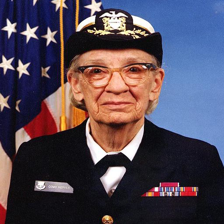

In [5]:
# `tf.keras.utils.get_file()` downloads a file from a URL if it not already in the cache
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [8]:
# `argmax()` returns the indices of the maximum values along an axis
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

Take the predicted class ID and fetch the `ImageNet` labels to decode the predictions

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

 8192/10484 [======================>.......] - ETA: 0s

16384/10484 [==============================================] - 0s 0us/step


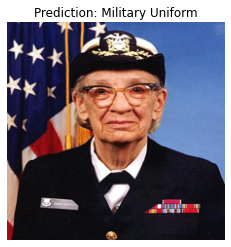

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

     8192/228813984 [..............................] - ETA: 3s

  5529600/228813984 [..............................] - ETA: 2s

  8396800/228813984 [>.............................] - ETA: 29s

 22028288/228813984 [=>............................] - ETA: 10s

 36569088/228813984 [===>..........................] - ETA: 6s 

 41713664/228813984 [====>.........................] - ETA: 5s

 50339840/228813984 [=====>........................] - ETA: 6s

 65110016/228813984 [=======>......................] - ETA: 4s

 79929344/228813984 [=========>....................] - ETA: 3s

 95092736/228813984 [===========>..................] - ETA: 2s

100671488/228813984 [============>.................] - ETA: 3s

115081216/228813984 [==============>...............] - ETA: 2s

130531328/228813984 [================>.............] - ETA: 1s

134225920/228813984 [================>.............] - ETA: 2s

148742144/228813984 [==================>...........] - ETA: 1s

159391744/228813984 [===================>..........] - ETA: 1s

167780352/228813984 [====================>.........] - ETA: 1s

182484992/228813984 [======================>.......] - ETA: 1s

197541888/228813984 [========================>.....] - ETA: 0s

201334784/228813984 [=========================>....] - ETA: 0s

211460096/228813984 [==========================>...] - ETA: 0s

226549760/228813984 [============================>.] - ETA: 0s

228818944/228813984 [==============================] - 6s 0us/step


Let's load this data into our model using  images off disk using image_dataset_from_directory.

In [12]:
batch_size = 32
img_height = 224
img_width = 224

# TODO: load the data into our model using images off disk using `image_dataset_from_directory`

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


The flowers dataset has five classes.

In [13]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


TensorFlow Hub's conventions for image models is to expect float inputs in the `[0, 1]` range. Use the `Rescaling` layer to achieve this.

Note: you could also include the `Rescaling` layer inside the model. See this [guide](https://www.tensorflow.org/guide/keras/preprocessing_layers) for a discussion of the tradeoffs.

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [17]:
result_batch = classifier.predict(train_ds)

In [18]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

Now check how these predictions line up with the images:

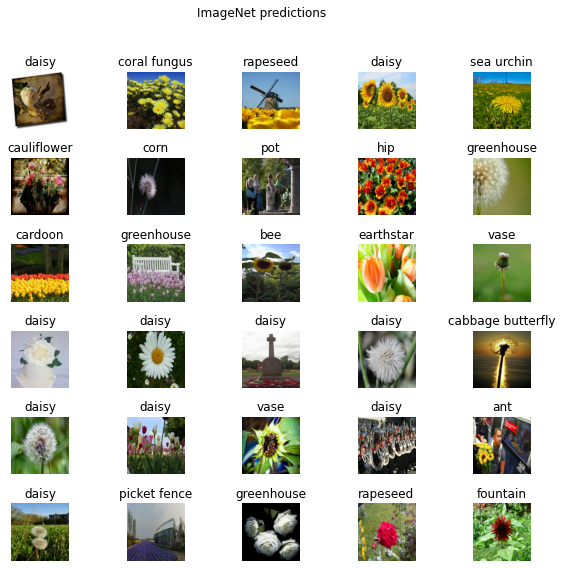

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [compatible image feature vector model](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [20]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

Create the feature extractor. Use `trainable=False` to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [21]:
# TODO: Create the feature extractor, use `trainable=False`

It returns a 1280-length vector for each image:

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [23]:
num_classes = len(class_names)

# TODO: Wrap the hub layer in a tf.keras.Sequential model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use compile to configure the training process:

In [26]:
# TODO: Use compile to configure the training process

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [27]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=2,
                    callbacks=[batch_stats_callback])

Epoch 1/2


 1/92 [..............................] - ETA: 0s - loss: 1.9394 - acc: 0.2188

 4/92 [>.............................] - ETA: 1s - loss: 1.6370 - acc: 0.2188

 7/92 [=>............................] - ETA: 1s - loss: 1.4566 - acc: 0.3438

10/92 [==>...........................] - ETA: 1s - loss: 1.3863 - acc: 0.3125

13/92 [===>..........................] - ETA: 1s - loss: 1.0194 - acc: 0.5938

16/92 [====>.........................] - ETA: 1s - loss: 1.3723 - acc: 0.5625

19/92 [=====>........................] - ETA: 1s - loss: 1.0671 - acc: 0.6250

22/92 [======>.......................] - ETA: 1s - loss: 0.8768 - acc: 0.7500

25/92 [=======>......................] - ETA: 1s - loss: 0.8353 - acc: 0.7500

28/92 [========>.....................] - ETA: 1s - loss: 0.6777 - acc: 0.7500

31/92 [=========>....................] - ETA: 1s - loss: 0.8061 - acc: 0.6875

34/92 [==========>...................] - ETA: 1s - loss: 0.9052 - acc: 0.6250

37/92 [===========>..................] - ETA: 0s - loss: 0.4712 - acc: 0.8438

40/92 [============>.................] - ETA: 0s - loss: 0.6830 - acc: 0.6875

43/92 [=============>................] - ETA: 0s - loss: 0.5463 - acc: 0.8125

46/92 [==============>...............] - ETA: 0s - loss: 0.6512 - acc: 0.7812

49/92 [==============>...............] - ETA: 0s - loss: 0.5102 - acc: 0.8750

52/92 [===============>..............] - ETA: 0s - loss: 0.4658 - acc: 0.8750

55/92 [================>.............] - ETA: 0s - loss: 0.7172 - acc: 0.6562

58/92 [=================>............] - ETA: 0s - loss: 0.4272 - acc: 0.8750

61/92 [==================>...........] - ETA: 0s - loss: 0.3275 - acc: 0.9688

64/92 [===================>..........] - ETA: 0s - loss: 0.7416 - acc: 0.7500

67/92 [====================>.........] - ETA: 0s - loss: 0.6403 - acc: 0.8438

70/92 [=====================>........] - ETA: 0s - loss: 0.4918 - acc: 0.8125

73/92 [======================>.......] - ETA: 0s - loss: 0.4281 - acc: 0.8750

76/92 [=======================>......] - ETA: 0s - loss: 0.4272 - acc: 0.8438

79/92 [========================>.....] - ETA: 0s - loss: 0.3393 - acc: 0.8438

82/92 [=========================>....] - ETA: 0s - loss: 0.5705 - acc: 0.8438

85/92 [==========================>...] - ETA: 0s - loss: 0.6477 - acc: 0.7812

88/92 [===========================>..] - ETA: 0s - loss: 0.7131 - acc: 0.7188

91/92 [============================>.] - ETA: 0s - loss: 0.4744 - acc: 0.9062

92/92 [==============================] - 2s 18ms/step - loss: 0.5942 - acc: 0.7500


Epoch 2/2


 1/92 [..............................] - ETA: 0s - loss: 0.2471 - acc: 0.9062

 4/92 [>.............................] - ETA: 1s - loss: 0.5293 - acc: 0.8438

 7/92 [=>............................] - ETA: 1s - loss: 0.3207 - acc: 0.9375

10/92 [==>...........................] - ETA: 1s - loss: 0.3200 - acc: 0.9062

13/92 [===>..........................] - ETA: 1s - loss: 0.3908 - acc: 0.9062

16/92 [====>.........................] - ETA: 1s - loss: 0.6908 - acc: 0.7188

19/92 [=====>........................] - ETA: 1s - loss: 0.4302 - acc: 0.8438

22/92 [======>.......................] - ETA: 1s - loss: 0.3617 - acc: 0.8438

25/92 [=======>......................] - ETA: 1s - loss: 0.2387 - acc: 0.9062

28/92 [========>.....................] - ETA: 1s - loss: 0.2716 - acc: 0.9375

31/92 [=========>....................] - ETA: 1s - loss: 0.3415 - acc: 0.9062

34/92 [==========>...................] - ETA: 0s - loss: 0.6385 - acc: 0.7188

37/92 [===========>..................] - ETA: 0s - loss: 0.2192 - acc: 0.9375

40/92 [============>.................] - ETA: 0s - loss: 0.4341 - acc: 0.8438

43/92 [=============>................] - ETA: 0s - loss: 0.3665 - acc: 0.9062

46/92 [==============>...............] - ETA: 0s - loss: 0.3844 - acc: 0.8750

49/92 [==============>...............] - ETA: 0s - loss: 0.2765 - acc: 0.8750

52/92 [===============>..............] - ETA: 0s - loss: 0.3088 - acc: 0.9062

55/92 [================>.............] - ETA: 0s - loss: 0.4997 - acc: 0.7812

58/92 [=================>............] - ETA: 0s - loss: 0.2062 - acc: 0.9688

61/92 [==================>...........] - ETA: 0s - loss: 0.1663 - acc: 1.0000

64/92 [===================>..........] - ETA: 0s - loss: 0.5270 - acc: 0.8438

67/92 [====================>.........] - ETA: 0s - loss: 0.4352 - acc: 0.8750

70/92 [=====================>........] - ETA: 0s - loss: 0.3532 - acc: 0.8750

73/92 [======================>.......] - ETA: 0s - loss: 0.2899 - acc: 0.9375

76/92 [=======================>......] - ETA: 0s - loss: 0.2819 - acc: 0.8750

79/92 [========================>.....] - ETA: 0s - loss: 0.2048 - acc: 1.0000

82/92 [=========================>....] - ETA: 0s - loss: 0.4422 - acc: 0.8438

85/92 [==========================>...] - ETA: 0s - loss: 0.5113 - acc: 0.8750

88/92 [===========================>..] - ETA: 0s - loss: 0.5872 - acc: 0.7812

91/92 [============================>.] - ETA: 0s - loss: 0.3175 - acc: 0.9062

92/92 [==============================] - 2s 17ms/step - loss: 0.3527 - acc: 0.9167


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

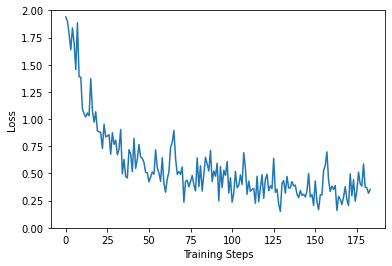

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

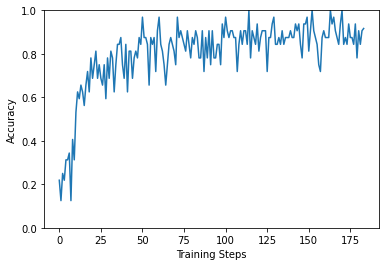

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

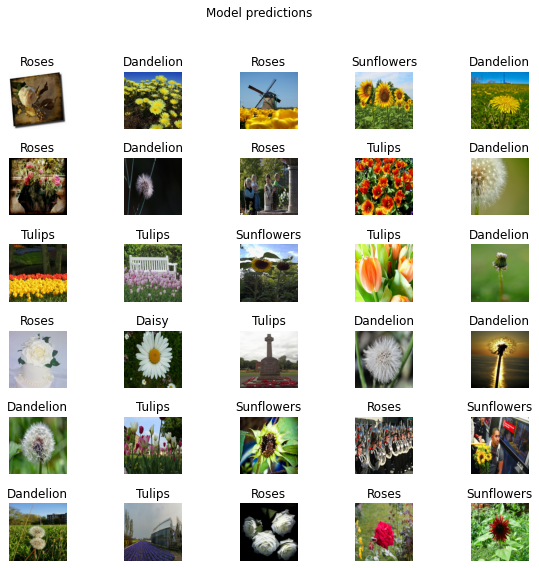

In [31]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
# imshow() function is used to display data as an image
  plt.imshow(image_batch[n])
# title() Set a title for the axes
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a SavedModel for use later on.

In [32]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_models/1605320639/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1605320639/assets


'/tmp/saved_models/1605320639'

Now confirm that we can reload it, and it still gives the same results:

In [33]:
# tf.keras.models.load_model() loads a model saved via model.save()
reloaded = tf.keras.models.load_model(export_path)

In [34]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [35]:
abs(reloaded_result_batch - result_batch).max()

0.0

This SavedModel can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).


## Learn more

Check out more [tutorials](https://www.tensorflow.org/hub/tutorials) for using image models from TensorFlow Hub.